### Check sample swap comparing genptypes from arrays and genotypes from ATAC-Seq
Method: Take SNPs in peaks that were selected for analysis ~200K and genotype usinf samtools mileup - Then select SNPs with average coverage of sites of 20x (57K) and filter the  vcfs files. Combine the VCFs and caluclate similarity of genotype using --relatedness function in vcftools


*** For more general use*** Alternatively use this list of snps: /home/pbenaglio/NGSCheckMate/SNP/SNP_GRCh37_hg19_wChr.bed

In [1]:
wd = '/nfs/lab/projects/pbmc_snATAC/analysis_v2/check_sample_swap/'

In [2]:
setwd(wd)

In [ ]:
## zgrep -v ^# ../rasqual/bulk/bulk/vcfs_peaksonly/full.ase.filtered.vcf.gz | awk -v OFS="\t" '{print $1,$2-1,$2}' > filtered_snp_inpeaks.bed

In [3]:
samples = paste0("PBMC", c(1:6, 8:10,12:15))

In [9]:
bam_files = paste(paste0("/nfs/lab/projects/pbmc_snATAC/analysis_v2/wasp/", samples, 
                   "/final/", samples, ".merged.rmdup.final.bam"), collapse=" ")

In [21]:
bam_files

[1] "/nfs/lab/projects/pbmc_snATAC/analysis_v2/wasp/PBMC1/final/PBMC1.merged.rmdup.final.bam /nfs/lab/projects/pbmc_snATAC/analysis_v2/wasp/PBMC2/final/PBMC2.merged.rmdup.final.bam /nfs/lab/projects/pbmc_snATAC/analysis_v2/wasp/PBMC3/final/PBMC3.merged.rmdup.final.bam /nfs/lab/projects/pbmc_snATAC/analysis_v2/wasp/PBMC4/final/PBMC4.merged.rmdup.final.bam /nfs/lab/projects/pbmc_snATAC/analysis_v2/wasp/PBMC5/final/PBMC5.merged.rmdup.final.bam /nfs/lab/projects/pbmc_snATAC/analysis_v2/wasp/PBMC6/final/PBMC6.merged.rmdup.final.bam /nfs/lab/projects/pbmc_snATAC/analysis_v2/wasp/PBMC8/final/PBMC8.merged.rmdup.final.bam /nfs/lab/projects/pbmc_snATAC/analysis_v2/wasp/PBMC9/final/PBMC9.merged.rmdup.final.bam /nfs/lab/projects/pbmc_snATAC/analysis_v2/wasp/PBMC10/final/PBMC10.merged.rmdup.final.bam /nfs/lab/projects/pbmc_snATAC/analysis_v2/wasp/PBMC12/final/PBMC12.merged.rmdup.final.bam /nfs/lab/projects/pbmc_snATAC/analysis_v2/wasp/PBMC13/final/PBMC13.merged.rmdup.final.bam /nfs/lab/projects/pbmc_snATAC/analysis_v2/wasp/PBMC14/final/PBMC14.merged.rmdup.final.bam /nfs/lab/projects/pbmc_snATAC/analysis_v2/wasp/PBMC15/final/PBMC15.merged.rmdup.final.bam"

In [ ]:
system(paste(
"samtools mpileup -t DP -l filtered_snp_inpeaks.bed -uf /home/joshchiou/references/male.hg19.fa", 
	bam_files, "| bcftools call -m -Ov > pbmc1_15.pileup.vcf"))



In [ ]:
#(grep ^# pbmc1_15.pileup.vcf; grep -v ^# pbmc1_15.pileup.vcf | sort -k1,1n -k2,2n) | bgzip -c > pbmc1_15.pileup.sorted.vcf.gz

# vcftools --gzvcf pbmc1_15.pileup.sorted.vcf.gz --site-mean-depth

In [13]:
depth = read.table("out.ldepth.mean", header=T)

In [14]:
dim(depth)

[1] 255288      4

In [15]:
subs = depth[depth$MEAN_DEPTH >20,]

In [16]:
dim(subs)

[1] 62281     4

In [19]:
bed = data.frame( subs$CHROM, subs$POS-1, subs$POS)

write.table(bed, "min20cov_snps.bed", col.names=F, sep="\t", quote=F, row.names=F)

In [24]:
writeLines(paste0(samples, "_snATAC"), "new_names")

In [ ]:
# vcftools --vcf pbmc1_15.pileup.vcf --bed min20cov_snps.bed --recode --out pileup

# vcftools --gzvcf ../rasqual/bulk/bulk/vcfs_peaksonly/full.chr.vcf.gz --bed min20cov_snps.bed --recode --out array

# bgzip array.recode.vcf
# bgzip pileup.recode.vcf
# tabix array.recode.vcf.gz
# tabix pileup.recode.vcf.gz


# bcftools reheader --samples new_names -o snATAC.recode.vcf.gz pileup.recode.vcf.gz
# tabix snATAC.recode.vcf.gz
# bcftools merge snATAC.recode.vcf.gz array.recode.vcf.gz -o merged.vcf

# vcftools --relatedness --vcf merged.vcf

In [25]:
rel = read.table('out.relatedness', header=T)

In [27]:
matches = rel [rel$RELATEDNESS_AJK >0.8,]
matches = matches[matches$INDV1 !=matches$INDV2,]

In [28]:
matches

,INDV1,INDV2,RELATEDNESS_AJK
,<fct>,<fct>,<dbl>
14,PBMC1_snATAC,PBMC1,0.919988
40,PBMC2_snATAC,PBMC2,0.886087
65,PBMC3_snATAC,PBMC3,0.929129
89,PBMC4_snATAC,PBMC4,0.892441
112,PBMC5_snATAC,PBMC5,0.895113
134,PBMC6_snATAC,PBMC6,0.929234
155,PBMC8_snATAC,PBMC8,0.925713
175,PBMC9_snATAC,PBMC9,0.907161
194,PBMC10_snATAC,PBMC10,0.906471


In [29]:
library(stringr)
library(tidyr)
library(pheatmap)

In [33]:
rel2 = rel[,c(2,1,3)]
colnames(rel2) = colnames(rel)
rel_full = rbind(rel, rel2)

rel_full = rel_full[!duplicated(rel_full),]

data_wide <- spread(rel_full, INDV2, RELATEDNESS_AJK)

rownames(data_wide) = data_wide[,1]
mat = data_wide[,-1]

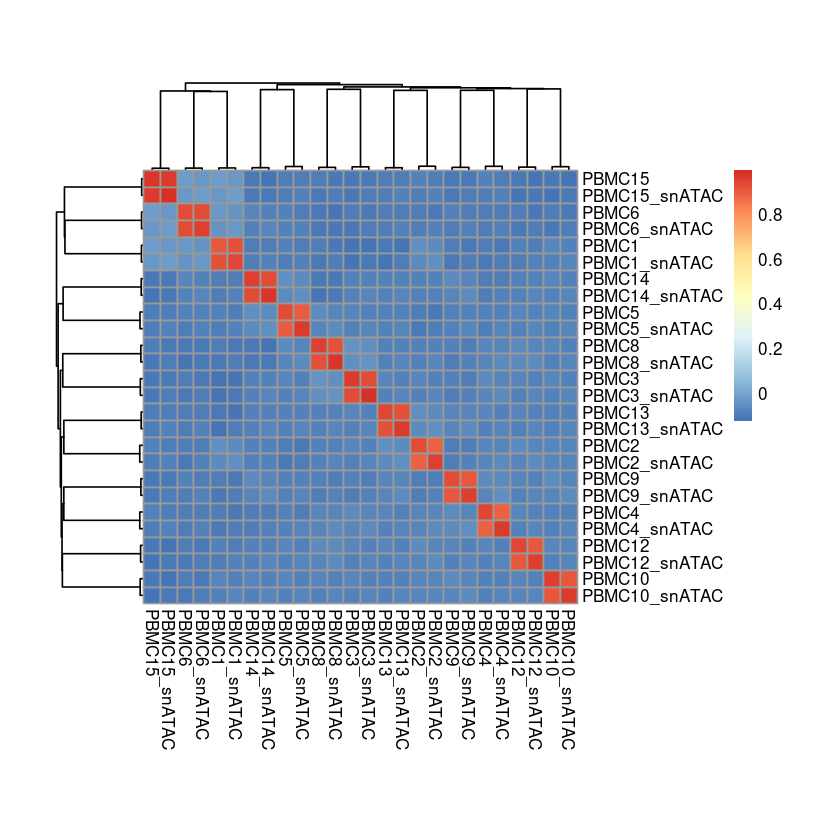

In [38]:
pheatmap(mat, cellwidth = 10,cellheight = 10)


Samples are matching correctly, you can even see the relatedness of the admixxed samples vs europeans